# 1. Vision Transformer Architecture

In [27]:
import warnings
warnings.filterwarnings('ignore')

import copy
import datetime
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import sys

from cv2 import resize
from datetime import datetime
from gc import collect
from os import cpu_count
from sklearn.model_selection import train_test_split
from time import sleep
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from tqdm import tqdm

sys.path.append(f"{os.getcwd()}/working ViT/")
sys.path.append(f"{os.getcwd()}/mltfm/")
sys.path.append(f"{os.getcwd()}/scripts/")
from VisionTransformer_working import VisionTransformer as vit_old

In [12]:
random_seed = 1
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
cudnn.benchmark = True

In [13]:
collect()
torch.cuda.empty_cache()
device = torch.device('cpu')
print(f"Running on device: {device}")

Running on device: cpu


### Comparison: CNN from [Kratz et al.](https://www.biorxiv.org/content/biorxiv/early/2022/09/03/2022.09.02.506331.full.pdf) and ViT

Load CNN and ViT model.

In [14]:
vit = vit_old(dspl_size=104, 
              patch_size=8, 
              embed_dim=128,
              depth=12,
              n_heads=8,
              mlp_ratio=4.,
              p=0.,
              attn_p=0.,
              drop_path=0.).double()

In [15]:
vit_multi = vit_old(dspl_size=104, 
              patch_size=8, 
              embed_dim=128,
              depth=12,
              n_heads=8,
              mlp_ratio=4.,
              p=0.,
              attn_p=0.,
              drop_path=0.).double()

In [16]:
path_to_pth = 'working ViT/logs_and_weights/ViT-2022-Dec-10 23:18:41/ViT-2022-Dec-10 23:18:41_best_val_loss_2.365828e-06.pth'

In [17]:
path_to_multi_pth = '/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/working ViT/logs_and_weights/ViT-2023-Jan-09 11:57:14/ViT-2023-Jan-09 11:57:14_best_val_loss_0.003215498429.pth'

In [18]:
if torch.cuda.is_available():
    vit.load_state_dict(torch.load(path_to_pth)['best_model_weights'], strict=True)
else:
    vit.load_state_dict(torch.load(path_to_pth, map_location=torch.device('cpu'))['best_model_weights'], strict=True)        

In [19]:
if torch.cuda.is_available():
    vit_multi.load_state_dict(torch.load(path_to_multi_pth)['best_model_weights'], strict=True)
else:
    vit_multi.load_state_dict(torch.load(path_to_multi_pth, map_location=torch.device('cpu'))['best_model_weights'], strict=True)        

In [20]:
cnn = keras.models.load_model('/home/alexrichard/PycharmProjects/UQ_DL-TFM/mltfm/models/model_noise_1e-4.h5')

Load test set of 50 clean samples.

In [21]:
os.getcwd()

'/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM'

In [22]:
dspl = h5py.File('data/Test data/resolution_104/allDisplacements')["dspl"]
trac = h5py.File('data/Test data/resolution_104/allTractions')["trac"]

dspl = np.moveaxis(np.concatenate([dspl[i] for i in range(dspl.shape[0])], axis=0), 3, 1)
trac_separated = np.moveaxis(np.concatenate([trac[i] for i in range(trac.shape[0])], axis=0), 3, 1)

X_test = torch.from_numpy(dspl).double().to(device)
Y_test = torch.from_numpy(trac_separated).double().to(device)

In [23]:
n_samples = X_test.shape[0]

In [24]:
Y_test.shape

torch.Size([100, 3, 104, 104])

Compute MSE, DTMA and DDA for the predictions.

In [25]:
vit.eval()
vit_multi.eval()
pred_vit = vit(X_test)
pred_vit_multi = vit_multi(X_test)
pred_cnn = cnn.predict(np.moveaxis(dspl, 1, 3))

4/4 [==============================] - 0s 42ms/step


In [28]:
from MultiTask import append_predictions_and_targets, dtma, dda, multi_task_loss

mse = torch.nn.MSELoss(reduction='none')
mse_vit = torch.mean(mse(pred_vit, Y_test[:, 0:2]), (1, 2, 3))
mse_vit_multi = torch.mean(mse(pred_vit_multi, Y_test[:, 0:2]), (1, 2, 3))
mse_cnn = torch.mean(mse(torch.tensor(np.moveaxis(pred_cnn, 3, 1)), Y_test[:, 0:2]), (1, 2, 3))

mse_vit = torch.reshape(mse_vit, (n_samples, 1))
mse_vit_multi = torch.reshape(mse_vit_multi, (n_samples, 1))
mse_cnn = torch.reshape(mse_cnn, (n_samples, 1))

In [29]:
appended_predictions, appended_targets = append_predictions_and_targets(pred_vit, Y_test, device)
dtma_vit = dtma(appended_predictions, appended_targets, device, True)
dda_vit = dda(appended_predictions, appended_targets, device, True)

In [30]:
appended_multi_predictions, appended_multi_targets = append_predictions_and_targets(pred_vit_multi, Y_test, device)
dtma_vit_multi = dtma(appended_multi_predictions, appended_multi_targets, device, True)
dda_vit_multi = dda(appended_multi_predictions, appended_multi_targets, device, True)

In [31]:
appended_cnn_predictions, appended_cnn_targets = append_predictions_and_targets(torch.tensor(np.moveaxis(pred_cnn, 3, 1)), Y_test, device)
dtma_cnn = dtma(appended_cnn_predictions, appended_cnn_targets, device, True)
dda_cnn = dda(appended_cnn_predictions, appended_cnn_targets, device, True)

In [32]:
dtma_vit = torch.reshape(dtma_vit, (n_samples, 1))
dtma_vit_multi = torch.reshape(dtma_vit_multi, (n_samples, 1))
dtma_cnn = torch.reshape(dtma_cnn, (n_samples, 1))
dda_vit = torch.reshape(dda_vit, (n_samples, 1))
dda_vit_multi = torch.reshape(dda_vit_multi, (n_samples, 1))
dda_cnn = torch.reshape(dda_cnn, (n_samples, 1))

In [33]:
alpha = 1/3
loss_vit_multi = alpha * mse_vit_multi + alpha * torch.sqrt(dtma_vit_multi ** 2) + alpha * dda_vit_multi

In [39]:
metrics = pd.DataFrame(
    np.array(torch.cat((mse_vit, 
                        mse_vit_multi, 
                        loss_vit_multi, 
                        mse_cnn, dtma_vit, 
                        dtma_vit_multi, 
                        dtma_cnn, dda_vit, 
                        dda_vit_multi, 
                        dda_cnn), 1).detach().numpy()), 
    columns=['Loss ViT', 
             'MSE ViT_multi', 
             'Loss ViT_multi', 
             'Loss CNN', 
             'DTMA ViT', 
             'DTMA ViT_multi', 
             'DTMA CNN', 
             'DDA ViT', 
             'DDA ViT_multi', 
             'DDA CNN'])
averages = pd.DataFrame(
    {'Loss ViT': f"avg: {round(metrics['Loss ViT'].mean(), ndigits=7)}",
     'MSE ViT_multi': f"avg: {round(metrics['MSE ViT_multi'].mean(), ndigits=7)}",
     'Loss ViT_multi': f"avg: {round(metrics['Loss ViT_multi'].mean(), ndigits=7)}", 
     'Loss CNN': f"avg: {round(metrics['Loss CNN'].mean(), ndigits=7)}",
     'DTMA ViT': f"avg: {round(metrics['DTMA ViT'].mean(), ndigits=7)}",
     'DTMA ViT_multi': f"avg: {round(metrics['DTMA ViT_multi'].mean(), ndigits=7)}",
     'DTMA CNN': f"avg: {round(metrics['DTMA CNN'].mean(), ndigits=7)}",
     'DDA ViT': f"avg: {round(metrics['DDA ViT'].mean(), ndigits=7)}",
     'DDA ViT_multi': f"avg: {round(metrics['DDA ViT_multi'].mean(), ndigits=7)}",
     'DDA CNN': f"avg: {round(metrics['DDA CNN'].mean(), ndigits=7)}"}, index=[0])
metrics = metrics.head(10)
metrics = metrics.append(averages, ignore_index=True)
metrics = metrics.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
metrics.set_properties(**{'text-align': 'center'}).hide_index()

Loss ViT,MSE ViT_multi,Loss ViT_multi,Loss CNN,DTMA ViT,DTMA ViT_multi,DTMA CNN,DDA ViT,DDA ViT_multi,DDA CNN
0.000078,0.000266,0.094741,0.000101,-0.029044,-0.104283,-0.077249,0.143926,0.179676,0.064444
0.000098,0.000302,0.092092,0.000098,-0.036466,-0.128815,-0.091900,0.122665,0.147159,0.063700
0.000034,0.000163,0.072425,0.000050,-0.021578,-0.099363,-0.070363,0.036333,0.117748,0.035573
0.000056,0.000202,0.128649,0.000068,-0.026164,-0.140919,-0.103649,0.140212,0.244826,0.070538
0.000045,0.000138,0.127369,0.000048,-0.052880,-0.142643,-0.100351,0.097162,0.239326,0.047689
0.000079,0.000204,0.107813,0.000065,-0.056208,-0.112487,-0.072087,0.111911,0.210749,0.062587
0.000081,0.000216,0.071167,0.000072,-0.022847,-0.095635,-0.064126,0.041375,0.117650,0.037123
0.000038,0.000125,0.152099,0.000038,-0.053711,-0.137853,-0.111679,0.189908,0.318320,0.057423
0.000057,0.000187,0.157687,0.000068,-0.036508,-0.134168,-0.104216,0.196178,0.338705,0.112032
0.000062,0.000197,0.047596,0.000064,-0.023005,-0.091353,-0.062254,0.040592,0.051237,0.036247


Visualize the first test sample, its ground truth and the models' predictions.

<IPython.core.display.Javascript object>


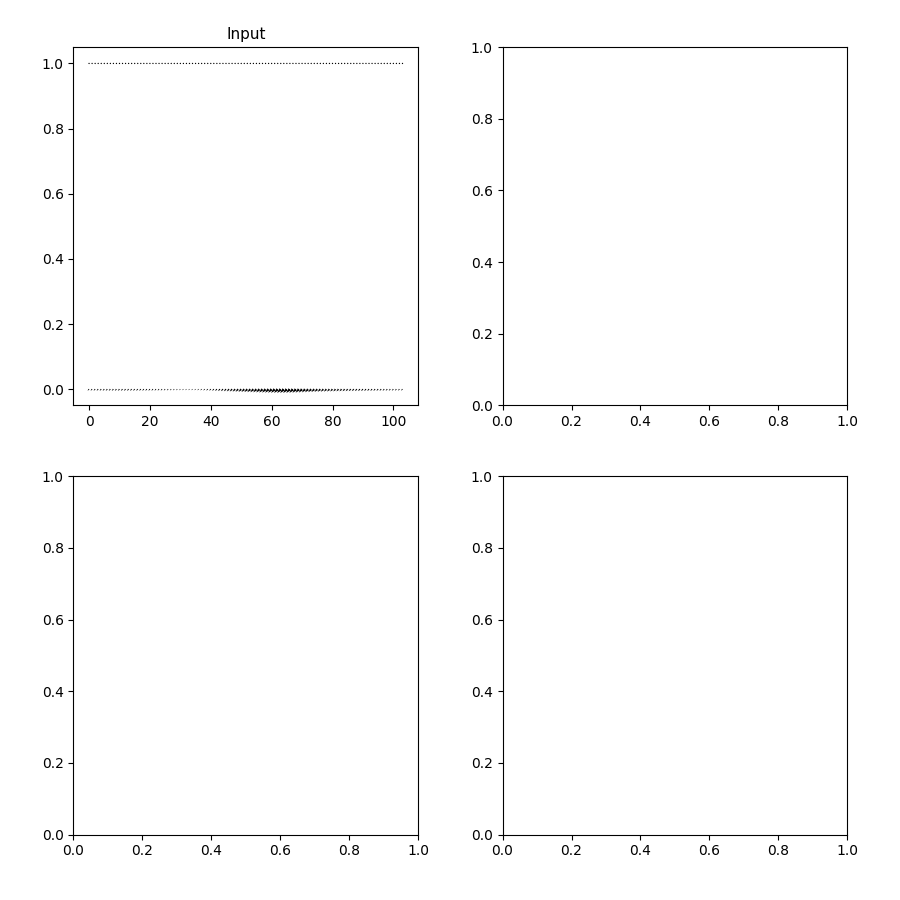

NameError: name 'trac_' is not defined

In [35]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(2, 2, figsize=(9, 9))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0, 0].quiver(dspl[0, :, :, 0], dspl[0, :, :, 1], scale=1)
axs[0, 0].set_title('Input', {'fontsize': 11})

axs[0, 1].quiver(trac_[0, 0, :, :], trac_[0, 1, :, :], scale=1)
axs[0, 1].set_title('Ground truth', {'fontsize': 11})

axs[1, 0].quiver(pred_vit[0, 0, :, :].detach().numpy(), pred_vit[0, 1, :, :].detach().numpy(), scale=1)
axs[1, 0].set_title(f'ViT prediction (loss: {torch.round(loss_vit[0, 0], decimals=3)})', {'fontsize': 11})

axs[1, 1].quiver(pred_cnn[0, :, :, 0], pred_cnn[0, :, :, 1], scale=1)
axs[1, 1].set_title(f'CNN prediction (loss: {torch.round(loss_cnn[0, 0], decimals=3)})', {'fontsize': 11})

### Visualization of attention maps

In [16]:
def compute_attention_map(attn_scores):
    """
    Compute the attention rollout tensors for each layer in a ViT architecture. We assume a batch size of 1.
    
    Parameters
    __________
    attn_scores : List
        List of raw attention tensors for each encoder block.
        
    Returns
    _______
    joint_attentions : List
        List of attention rollouts for each layer.
    
    grid_size : int
        Number of patches per dimension of original (quadratic) input.
    """
    # Stack raw attention tensors in a matrix, get rid of singleton (batch) dimension and average over all attention heads per layer.
    attn_mat = torch.stack(attn_scores) # (depth, n_samples, n_heads, n_patches, n_patches)
    attn_mat = attn_mat.squeeze(1) # (depth, n_heads, n_patches, n_patches)
    attn_mat = torch.mean(attn_mat, dim=1) # (depth, n_heads, n_patches, n_patches)
    
    # Account for skip connections in the architecture
    residual_attn = torch.eye(attn_mat.size(1))
    aug_attn_mat = attn_mat + residual_attn
    aug_attn_mat = aug_attn_mat / aug_attn_mat.sum(dim=-1).unsqueeze(-1)
    
    # Recursively compute attention rollouts 
    joint_attentions = torch.zeros(aug_attn_mat.size())
    joint_attentions[0] = aug_attn_mat[0].double()
    for n in range(1, aug_attn_mat.size(0)):
        joint_attentions[n] = aug_attn_mat[n].double() @ joint_attentions[n-1].double()
    
    grid_size = int(np.sqrt(aug_attn_mat.size(-1)))
    
    return joint_attentions, grid_size

We extract the attention weights of each encoder block for the first test sample and compute the attention rollouts.

In [17]:
_, attn_scores = vit((X_test[0, :, :, :][np.newaxis, ...]), return_attention=True)
joint_attentions, grid_size = compute_attention_map(attn_scores)

Visualize the test sample and select one patch. We will then track the attention rollout of this patch among the network.

<IPython.core.display.Javascript object>


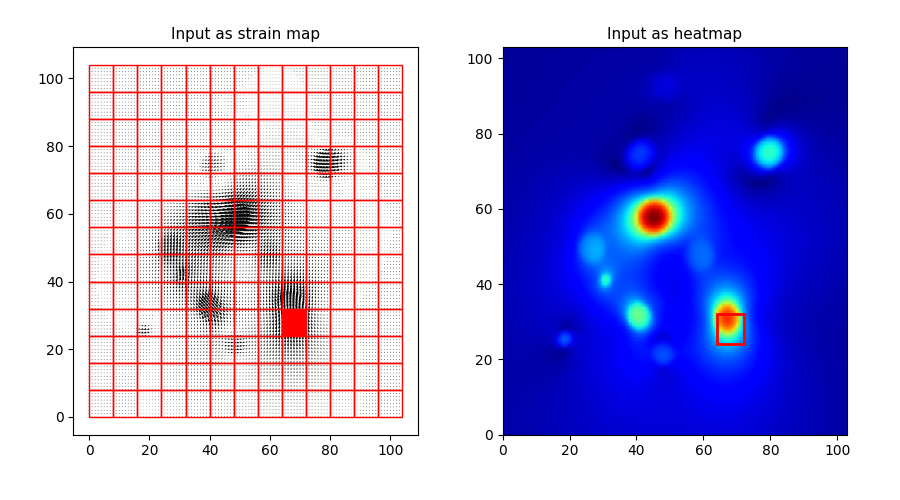

In [18]:
from matplotlib.patches import Rectangle

fig, axs = plt.subplots(1, 2, figsize=(9, 5))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0].quiver(X_test[0, 0, :, :], X_test[0 ,1 ,: , :], scale=1)
axs[0].set_title('Input as strain map', {'fontsize': 11})

C = np.sqrt(X_test[0, 0, :, :] **2 + X_test[0, 1, :, :] ** 2)
im = axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].set_title('Input as heatmap', {'fontsize': 11})


for row in range(0, 13):
    for column in range(0, 13):
        if row == 3 and column == 8:
            axs[0].add_patch(Rectangle(xy=(column*8, row*8), width=8, height=8, linewidth=1, color='red', fill=True))
        else:
            axs[0].add_patch(Rectangle(xy=(column*8, row*8), width=8, height=8, linewidth=1, color='red', fill=False))
    
    
axs[1].add_patch(Rectangle(xy=(8*8, 3*8), width=8, height=8, linewidth=2, color='red', fill=False))

Plot rolled out attention map of chosen patch at each layer of the encoder.

<IPython.core.display.Javascript object>


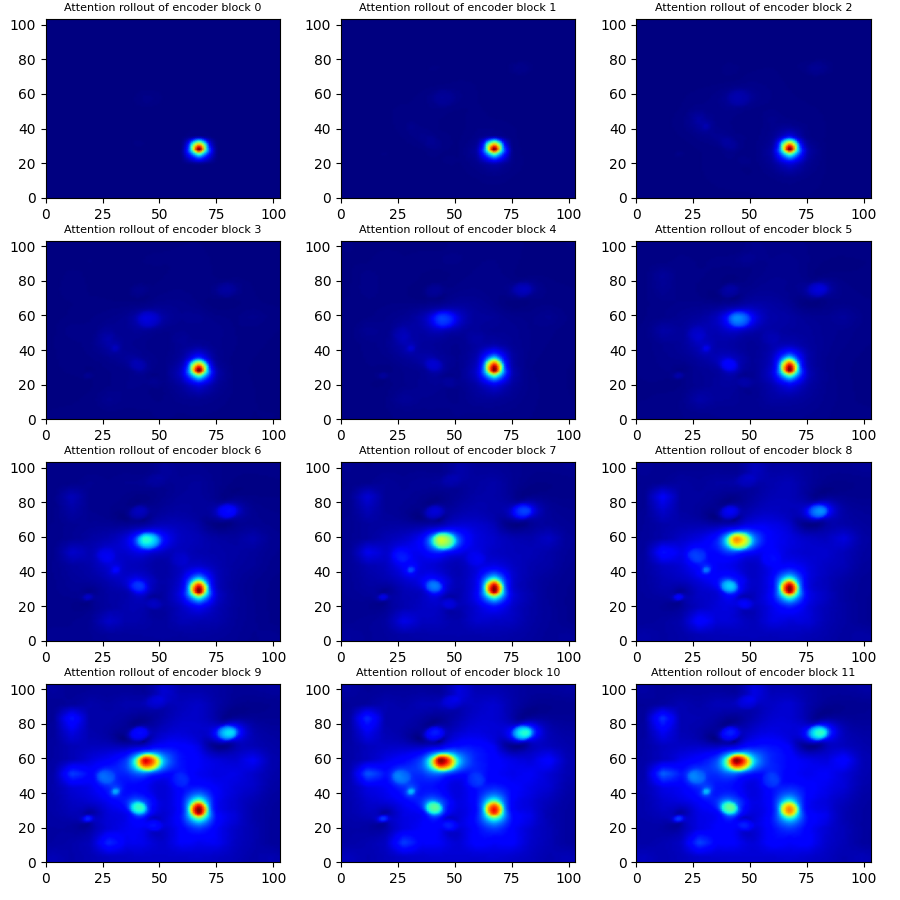

In [19]:
fig, axs = plt.subplots(4, 3, figsize=(9, 9))
fig.tight_layout(pad=1, w_pad=1, h_pad=1)
ind = 0
for i in range(0, 4):
    for j in range(0, 3):
        mask = joint_attentions[ind][47, 0:].reshape(grid_size, grid_size).detach().numpy()
        mask = resize(mask / mask.max(), (104, 104))
        mask = mask[np.newaxis, ...]
        result = torch.tensor(mask) * X_test[0,:,:,:]

        C = np.sqrt(result[0,:,:] **2 + result[1,:,:] ** 2)
        im = axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[i, j].set_title(f'Attention rollout of encoder block {ind}', {'fontsize': 8})
        ind += 1

Next, another test sample with a more "cell-like" geometry is analysed.

In [20]:
os.chdir('..')
sys.path.append(f"{os.getcwd()}/DL_TFM/scripts/")
from data_preparation import matFiles_to_npArray

In [21]:
X_test_ = matFiles_to_npArray('comparables/generic')[1]
Y_test_ = matFiles_to_npArray('comparables/generic')[0]
X_test_ = np.moveaxis(np.array(X_test_['dspl'])[np.newaxis, ...], 3, 1)
Y_test_ = np.moveaxis(np.array(Y_test_['trac'])[np.newaxis, ...], 3, 1)

In [22]:
_, attn_scores = vit(torch.tensor(X_test_).double(), True)
joint_attentions, grid_size = compute_attention_map(attn_scores)

<IPython.core.display.Javascript object>


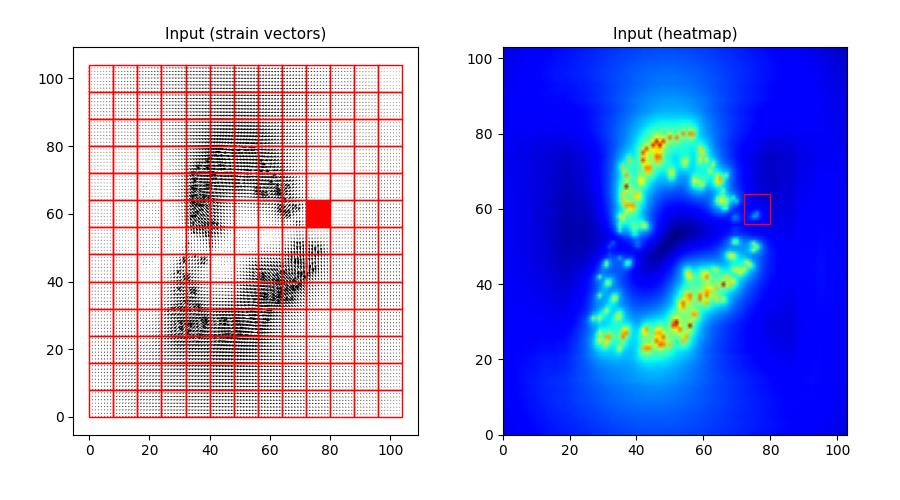

In [23]:
from matplotlib.patches import Rectangle

fig, axs = plt.subplots(1,2, figsize=(9, 5))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0].quiver(X_test_[0,0,:,:], X_test_[0,1,:,:], scale=20)
axs[0].set_title('Input (strain vectors)', {'fontsize': 11})

C = np.sqrt(X_test_[0,0,:,:] **2 + X_test_[0,1,:,:] ** 2)
im = axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].set_title('Input (heatmap)', {'fontsize': 11})


for row in range(0, 13):
    for column in range(0, 13):
        if row == 7 and column == 9:
            axs[0].add_patch(Rectangle(xy=(column*8, row*8), width=8, height=8, linewidth=1, color='red', fill=True))
        else:
            axs[0].add_patch(Rectangle(xy=(column*8, row*8), width=8, height=8, linewidth=1, color='red', fill=False))
    
    
axs[1].add_patch(Rectangle(xy=(9*8, 7*8), width=8, height=8, linewidth=1, color='red', fill=False))

<IPython.core.display.Javascript object>


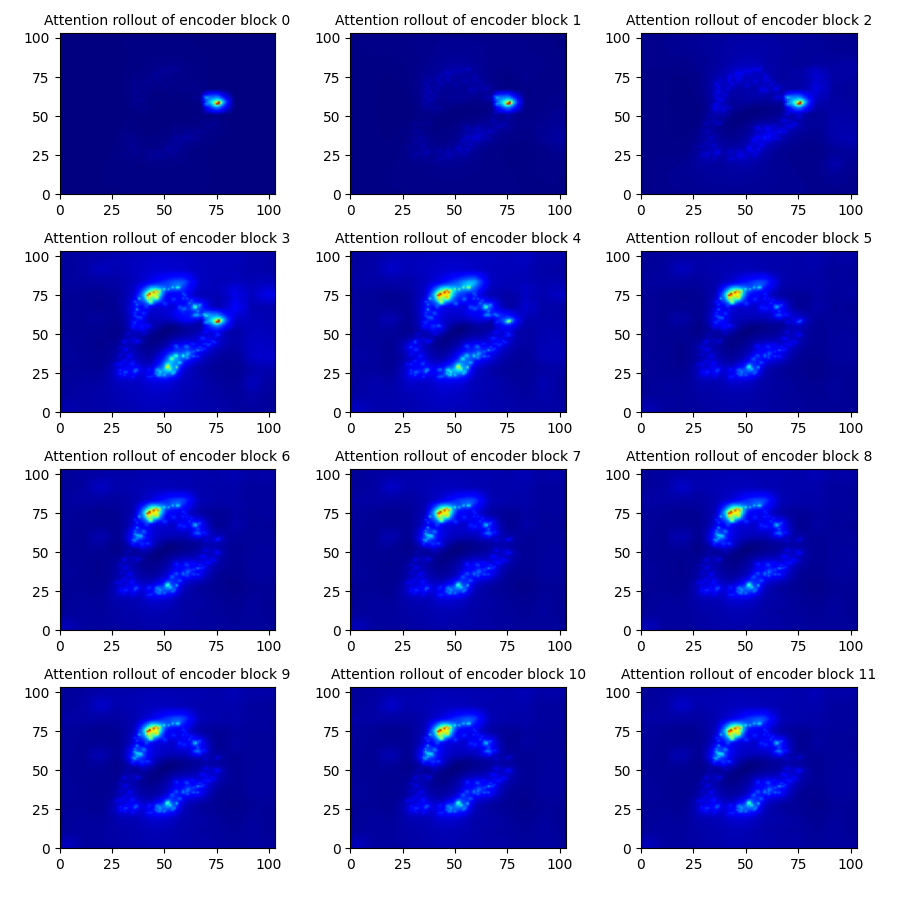

In [24]:
fig, axs = plt.subplots(4, 3, figsize=(9, 9))
fig.tight_layout(pad=2, w_pad=2, h_pad=2)
ind = 0
for i in range(0, 4):
    for j in range(0, 3):
        mask = joint_attentions[ind][100, 0:].reshape(grid_size, grid_size).detach().numpy()
        mask = resize(mask / mask.max(), (104, 104))
        mask = mask[np.newaxis, ...]
        result = torch.tensor(mask) * X_test_[0,:,:,:]

        C = np.sqrt(result[0,:,:] **2 + result[1,:,:] ** 2)
        im = axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[i, j].set_title(f'Attention rollout of encoder block {ind}', {'fontsize': 10})
        ind += 1